# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

We will build a Convolution Neural Network to recognize Traffic signs. We will use German Traffic Sign dataset to train our model. 

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Keep a copy of the orignal data
X_train_original = X_train
X_test_original = X_test
y_train_original = y_train
y_test_original = y_test

# Model save path
model_Save_Path = './Checkpoints/traffic_signs_model.ckpt'

---

## Step 1: Dataset Summary & Exploration

In [2]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train)[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Explore data with some plots

In [3]:
# Number of unique symbols
n_signs = np.unique(y_train).size
print("There are %d unique Traffic Signs in the training set"%(n_signs))

There are 43 unique Traffic Signs in the training set


### Map classes to Sign names

In [4]:
# We only know classes as number. We need to read the mapping to actual Sign Names
import csv
signName = {}
with open('./signnames.csv') as file:
    reader = csv.reader(file)
    for line in reader:
        signName[line[0]] = line[1]

### Randomly pick some images and plot them along with thier labels

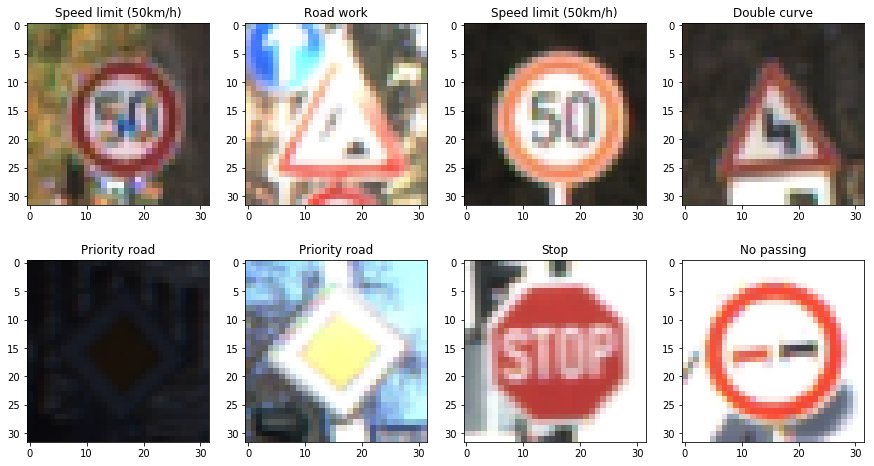

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.figure(figsize=(15, 8))
for i in range(8):
    index = np.random.randint(1,high = n_train)
    plt.subplot(2,4,i+1)
    plt.imshow(X_train_original[index])
    plt.title(str(signName[str(y_train_original[index])]))

### Sample Distribution

The distribution shows that the number of samples for each class is varied. There are very few samples for about 60% of the examples. There will be need for Data Augmentation to amplify our sample space.

[]

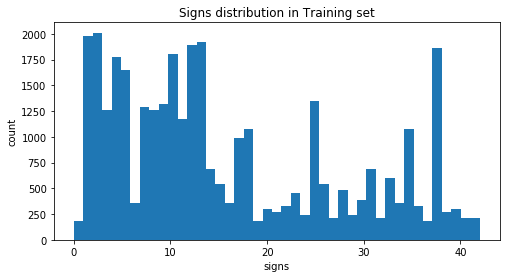

In [6]:
plt.figure(figsize=(8, 4))
plt.title('Signs distribution in Training set')
plt.hist(y_train, bins=n_signs)
plt.xlabel('signs')
plt.ylabel('count')
plt.plot()

----

## Step 2: Design and Test a Model Architecture

We will implement a deep learning model that learns to recognize traffic signs. We will train and test our model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

We will use a modification of LeNet Architecture. 

- Prepeocessing
- Model Architecture
- Train and save the model
- Plot Validation and Test results

### Pre-process the Data Set

There are many preprocessing techniques we can choose from. This [article](goo.gl/23S5wn) summarizes the most used preprocessing techniques.
- We will choose not to Greyscale the images because we are not sure if different color backgrounds like yellow, blue or white has different meaning that the network can learn.
- We will use Normalization as opposed to Standardization
  ![Narmalization](./normalization.png)
  Normalization is one of the feature scaling methods. Normalised data improves convergence during Gradient descent. Although image features are always in the range of [0-255] without any scope for outliers, it is observed that normalizing an image considerably improves performance. 
  
  
- Data Augmentation helps us increase our training sample size with additional distorted images. Collecting training data is time consuming and a costly affair. Data Augmentation has proven to be a easier alternative to an extent. We will use Keras's [ImageDataGenerator](https://keras.io/preprocessing/image/) for data Augmentation. This library provides option to distort image in several ways. 

### References:
- [Data Augmentation](https://www.coursera.org/learn/convolutional-neural-networks/lecture/AYzbX/data-augmentation) and [Normalization](https://www.coursera.org/learn/deep-neural-network/lecture/lXv6U/normalizing-inputs) from Prof Andrew Ng's course on Deep Learning. The course is remarkable. 
- Blog on Keras [ImageDataGenrator](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)

In [7]:
def normalize(X):
    return (X - np.mean(X)) / (np.max(X)-np.min(X))
    
def standardize(X):
    return (X - np.mean(X)) / np.std(X_train)

In [8]:
def plot_norm_image(index):
    plt.figure(figsize=(10, 6))
    
    plt.subplot(3,3,1)
    plt.imshow(X_train[index])
    plt.title('Orignal')
    
    plt.subplot(3,3,2)
    plt.imshow(normalize(X_train[index]))
    plt.title('Normalized')
    
    plt.subplot(3,3,3)
    plt.imshow(standardize(X_train[index]))
    plt.title('Standardized')

In [9]:
def preprocess_images(X, type = 'normalize'):
    if type == 'normalize':
        return normalize(X)
    elif type == 'standardize':
        return standardize(X)
    else:
        return False

### Visualise Image after Normalization/Standardization

Let's visualise Orignal, Normalized and Standardized versions of a random image,

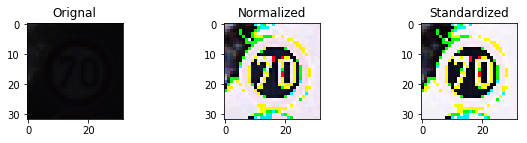

In [10]:
plt.figure(figsize=(15, 8))
plot_norm_image(np.random.randint(1,high = n_train))

---
### Preprocess image and Split into Train and Validation set
- We shuffle to data so each batch will have a mix of images from all the classes. This keeps the loss curve smoother.
- We normalize the data.
- We split 20% of the training data for validation set. We will use the Validation set to tune our model later.

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train)

X_train_norm = preprocess_images(X_train)
X_test_norm = preprocess_images(X_test)

X_train_norm, X_valid_norm, y_train, y_valid = train_test_split(X_train_norm, y_train,test_size=0.2, random_state=101)

### Keras ImageDataGenerator
These are the abberations we will use for our data augmentation
- Rotations between 0 to 20 degrees in both left and right direction
- Shift width by range of 10%
- Shift height by range of 10%
- Zoom image by range of 20%

ImageDataGenration performs data augmenation at runtime so it doesn't have to store preprocessed images. This helps conserve disk space.

Using TensorFlow backend.


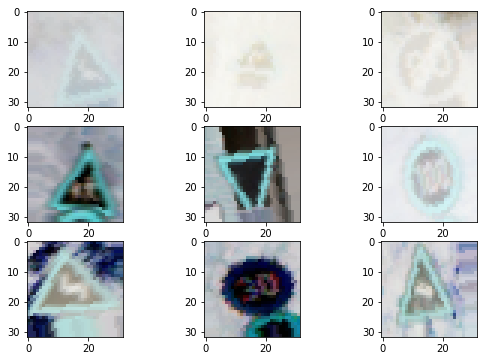

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20.,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2)

# Configure batch size and retrieve one batch of images
plt.figure(figsize=(9, 6))
for X_sample, y_sample in datagen.flow(X_train_original, y_train_original, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_sample[i].reshape(32, 32, 3))
    plt.show()
    break

### Model Architecture

We will use a modification of LeNet architechture.

- CONV1  
    - Dimensions: Input 32x32x3, Output 28x28x16
    - Filters: 16 of 5x5 filters, VALID padding
    - Activation: ReLu

- POOL1
    - Dimensions: Input 28x28x16, Output 14x14x16
    - Kernel size: 2x2, Stride: 2x2, VALID Padding   
   
- CONV2
    - Dimensions: Input 14x14x16, Output 10x10x64
    - Filters: 64 of 5x5 filters, VALID padding
    - Activation: ReLu
- POOL2
    - Dimensions: Input 10x10x64, Output 5x5x64
    - Kernel size: 2x2, Stride: 2x2, VALID Padding     
  
- FC0
    - Dimensions: Input: 5x5x64, Output 1600
- FC1 
    - Dimensions: Input: 1600, Output 240
    - Dropout: Keep probablity: 0.6
    - Activation: ReLu
- FC2 
    - Dimensions: Input: 0.6 of 240, Output 84
    - Dropout: Keep probablity: 0.6
    - Activation: ReLu
- FC3 
    - Dimensions: Input: 0.6 of 84, Output 43

In [13]:
# Helper functions
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def get_weight_variable(shape, mu=0.0, sigma=0.1):
    initial = tf.truncated_normal(shape, stddev=sigma, mean=mu)
    return tf.Variable(initial)

def get_bias_variable(shape,val=0.0):
    initial = tf.constant(val, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)

def maxpool2d(x, kernel_size=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
    return tf.nn.max_pool(x, ksize=kernel_size, strides=strides, padding=padding)


In [14]:
# LeNet
def LeNet(x):
    # CONV1 Input: 32x32x3 -> 28x28x16
    conv1_W = get_weight_variable(shape=(5, 5, 3, 16))
    conv1_b = get_bias_variable(shape=(16,))
    conv1 = conv2d(x, conv1_W, padding = 'VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # POOL1 Input: 28x28x16 Output: 14x14x16
    pool1 = maxpool2d(conv1)

    # CONV2 Input: 14x14x16 Output: 10x10x64
    conv2_W = get_weight_variable(shape=(5, 5, 16, 64))
    conv2_b = get_bias_variable(shape=(64,))
    conv2 = conv2d(pool1, conv2_W) + conv2_b
    conv2 = tf.nn.relu(conv2)

    # POOL2 Input: 10x10x64 Output: 5x5x64
    pool2 = maxpool2d(conv2)
    
    # FC0 Input: 5x5x64 Output:  1600
    fc0 = flatten(pool2)
    
    # FC1 Input: 1600 Output: 240
    fc1_W = get_weight_variable(shape=(1600, 240))
    fc1_b = get_bias_variable(shape=(240,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Applying Dropout before activation provides some computational advantage
    fc1 = tf.nn.dropout(fc1, keep_prob=0.6)
    fc1 = tf.nn.relu(fc1)
    
    # FC2 Input: keep_probs of 240 Output: 84
    fc2_W = get_weight_variable(shape=(fc1._shape[1].value, 84))
    fc2_b = get_bias_variable(shape=(84,))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob=0.6)
    fc2 = tf.nn.relu(fc2)
    
    # FC3 Input: keep_probs of 84 Output: 43
    fc3_W = get_weight_variable(shape=(fc2._shape[1].value, 43))
    fc3_b = get_bias_variable(shape=(43,))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return (logits, conv1, conv2, fc1, fc2)

In [15]:
# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [16]:
# Training steps
lr = 0.001
logits, conv1, conv2, fc1, fc2 = LeNet(x)
# If lebels NOT one-hot-encoded, use sparse_softmax_cross_entropy_with_logits
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss_function)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Parameters used for Training
- Dropout = 0.6
- Epochs = 30
- Batch size = 32
- Learning rate = 0.001
- Optimizer = Adam

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [18]:
BATCH_SIZE = 32
EPOCHS = 30

In [19]:
validation_accuracy_epochs = np.zeros((EPOCHS), dtype=np.float64)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    validation_accuracy = 0.0
    
    for i in range(EPOCHS):
        print("EPOCH {}".format(i + 1))
        batches = 0
        for x_batch, y_batch in datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE):
            batches += 1
            sess.run(train_step, feed_dict={x: x_batch, y: y_batch, keep_prob: 0.6})
            if batches >= len(X_train_norm) / BATCH_SIZE:
                break
        
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        validation_accuracy_epochs[i] = validation_accuracy

        train_accuracy = evaluate(X_train_norm, y_train)
        test_accuracy = evaluate(X_test, y_test)
        print('Accuracy: Train: {:.3f}, Validation: {:.3f}, Test: {:.3f}'\
                .format(train_accuracy, validation_accuracy, test_accuracy))
    
    print('Finishes training')
    saver.save(sess, model_Save_Path)

EPOCH 1
Accuracy: Train: 0.556, Validation: 0.554, Test: 0.533
EPOCH 2
Accuracy: Train: 0.779, Validation: 0.769, Test: 0.652
EPOCH 3
Accuracy: Train: 0.850, Validation: 0.849, Test: 0.709
EPOCH 4
Accuracy: Train: 0.900, Validation: 0.897, Test: 0.752
EPOCH 5
Accuracy: Train: 0.933, Validation: 0.928, Test: 0.766
EPOCH 6
Accuracy: Train: 0.955, Validation: 0.947, Test: 0.853
EPOCH 7
Accuracy: Train: 0.948, Validation: 0.943, Test: 0.775
EPOCH 8
Accuracy: Train: 0.967, Validation: 0.959, Test: 0.820
EPOCH 9
Accuracy: Train: 0.964, Validation: 0.960, Test: 0.827
EPOCH 10
Accuracy: Train: 0.974, Validation: 0.970, Test: 0.838
EPOCH 11
Accuracy: Train: 0.973, Validation: 0.972, Test: 0.839
EPOCH 12
Accuracy: Train: 0.982, Validation: 0.974, Test: 0.812
EPOCH 13
Accuracy: Train: 0.981, Validation: 0.978, Test: 0.857
EPOCH 14
Accuracy: Train: 0.982, Validation: 0.979, Test: 0.847
EPOCH 15
Accuracy: Train: 0.985, Validation: 0.983, Test: 0.841
EPOCH 16
Accuracy: Train: 0.988, Validation: 0.98

### Time for results

In [20]:
import tensorflow as tf
with tf.Session() as sess:
    # restore saved session
    saver.restore(sess, model_Save_Path)
    valid_accuracy = evaluate(X_valid_norm, y_valid)
    test_accuracy = evaluate(X_test_norm, y_test)
    print('Performance on Validation set: {:.3f}'.format(valid_accuracy))
    print('Performance on test set: {:.3f}'.format(test_accuracy))

Performance on Validation set: 0.990
Performance on test set: 0.944


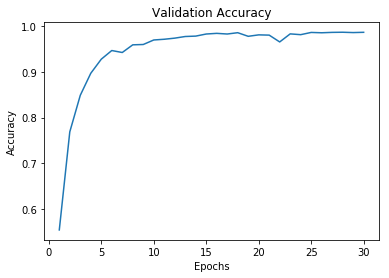

In [21]:
plt.plot(range(1, EPOCHS+1), validation_accuracy_epochs)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

---

## Step 3: Test a Model on New Images

We download 12 Traffic signs from Web belonging to two categories
- Classes that have training sample size of above 1000.
- Classes that have training sample size of less than 1000.

### Predict the Sign Type for Each Image

In [23]:
import tensorflow as tf
import os
import cv2

signs_dir1 = './new_signs'
signs_dir2 = './new_signs_rare'

def make_dataset_new_signs(new_signs_dir):
    new_signs = [os.path.join(new_signs_dir, file) for file in os.listdir(new_signs_dir)]
    new_signs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_signs]
    return new_signs

def predict(image):
    clas = np.zeros(6,dtype=np.int8)
    with tf.Session() as sess:
        saver.restore(sess, model_Save_Path)
        clas = sess.run(tf.argmax(logits,1), feed_dict={x:image, keep_prob:1.})
    return clas    

def predict_and_plot(new_signs_dir, actual_labels):
    new_signs = make_dataset_new_signs(new_signs_dir)
    new_signs_norm = preprocess_images(new_signs)
    classes = predict(new_signs_norm)

    plt.figure(figsize=(12, 15))
    for i in range(0, 6):
        indeces = [j for j,x in enumerate(y_train_original.tolist()) if x==actual_labels[i]]
        plt.subplot(330 + 1 + i)
        plt.imshow(new_signs[i])
        plt.xlabel('PREDICTED: '+ signName[str(classes[i])]+'\n'+ 'ACTUAL: '+ \
                   signName[str(actual_labels[i])] +'\n'+ 'TRAINED_WITH:' + str(np.size(indeces,0)) + ' examples')
    plt.show()

### Performance on Test images of classes with larger training sample size

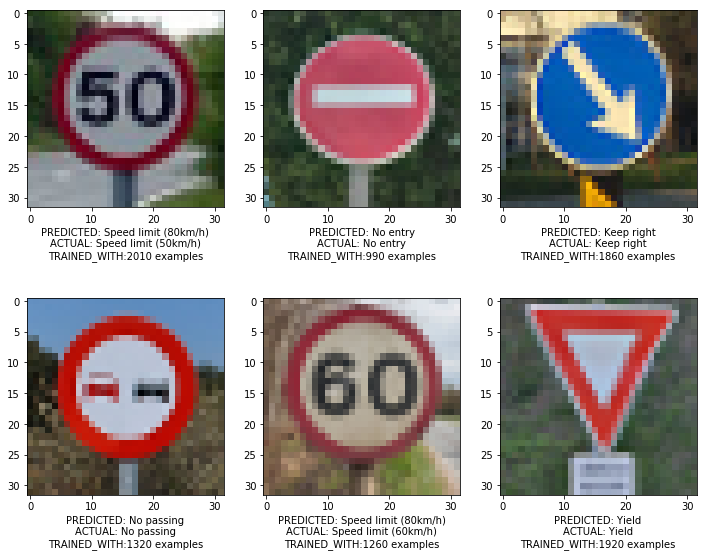

In [31]:
actual_labels = [2,17,38,9,3,13]
predict_and_plot(signs_dir1, actual_labels)

We see that 4 of 6 predictions are right bringing the performace figure to 66.66%.
Sometimes, when the model is trained again, We see that 5 of 6 predictions are right bringing the performace figure to 83.33%.
- The Traffic sign that it gets wrong is 'Speed limit 60km/h' and 'Speed limit 50km/h' which looks like 80km/hr. The culprit seems to be image resolution since both of these images are Speed limit images.
- However, if we consider human accuracy as a baseline, we see that our model suffers from high bias.

### Performance on Test images of classes with smaller training sample size



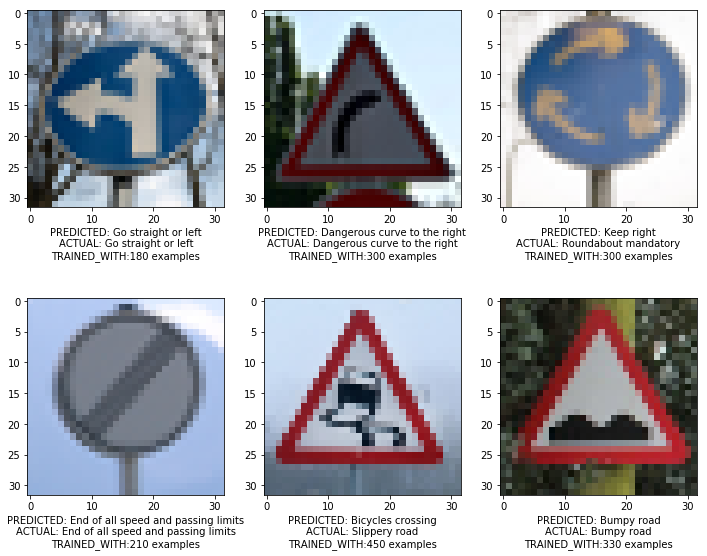

In [33]:
actual_labels = [37,20,40,32,23,22]
predict_and_plot(signs_dir2, actual_labels)

We see that 4 of 6 predictions are right bringing the performace figure to 66.66%.
Sometimes, when the model is trained again, We see that 5 of 6 predictions are right bringing the performace figure to 83.33%. It's funny that it happens when I run on AWS but not on my local computer.
- The Traffic sign that it gets wrong is 'Slippery road'. Low resolution seems to be the begger problem.
- The other sign it gets wrong is 'Roundabout'. It confuses it for 'Keep Right' which is a subset of 'Roundabout' if you look at the image carefully. In this case it looks like having less training example and low resolution is the culprit.

It is surprising that despite being trained on comparitively smaller training example size, the performace is equal to the one's with larger training sample size. If human error is to be considered as a Bayes error rate, then it looks like our model suffers from huge bias. Things we can do:
- Better images and higher resolution.
- A bigger network.
- Training longer.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Let's print top 5 softmax probablities for each of our test images. It would help us check if the correct predictions appear in the top 5 probablities.

In [36]:
signs_dir = './new_signs_rare'
actual_labels = [37,20,40,32,23,22]

new_signs = make_dataset_new_signs(signs_dir)
new_signs_norm = preprocess_images(new_signs)

with tf.Session() as sess:
    saver.restore(sess,model_Save_Path)
    
    top_5 = sess.run(tf.nn.top_k(logits,k=5), feed_dict={x:new_signs_norm, keep_prob:1.})
    
    probs = sess.run(tf.nn.softmax(logits), feed_dict={x:new_signs_norm, keep_prob:1.})

for i in range(len(new_signs)):
    print('Top 5 model predictions for image '+str(i)+' Actual label is:' + str(actual_labels[i]) + '\n')
    for j in range(5):
        top = top_5[1][i][j]
        print('Prediction '+ str(top) +' confidence: '+ str(round(probs[i][top],5)))
    print('\n')

Top 5 model predictions for image 0 Actual label is:37

Prediction 35 confidence: 0.00122
Prediction 37 confidence: 0.74575
Prediction 34 confidence: 0.24819
Prediction 36 confidence: 4e-05
Prediction 38 confidence: 0.00305


Top 5 model predictions for image 1 Actual label is:20

Prediction 20 confidence: 0.01173
Prediction 26 confidence: 0.98826
Prediction 25 confidence: 0.0
Prediction 28 confidence: 1e-05
Prediction 18 confidence: 0.0


Top 5 model predictions for image 2 Actual label is:40

Prediction 38 confidence: 0.02439
Prediction 40 confidence: 0.92278
Prediction 4 confidence: 0.0
Prediction 31 confidence: 0.0
Prediction 36 confidence: 0.00038


Top 5 model predictions for image 3 Actual label is:32

Prediction 32 confidence: 0.92966
Prediction 41 confidence: 0.07033
Prediction 26 confidence: 0.0
Prediction 6 confidence: 1e-05
Prediction 9 confidence: 0.0


Top 5 model predictions for image 4 Actual label is:23

Prediction 23 confidence: 0.0
Prediction 31 confidence: 0.0
Predi

It looks like if the prediction is wrong, the actual class appears second in softmax probablity's list. However, the margin between the first and the second probablities is very high. That means, for those wrong predicted classes, the bias is very high.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [37]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

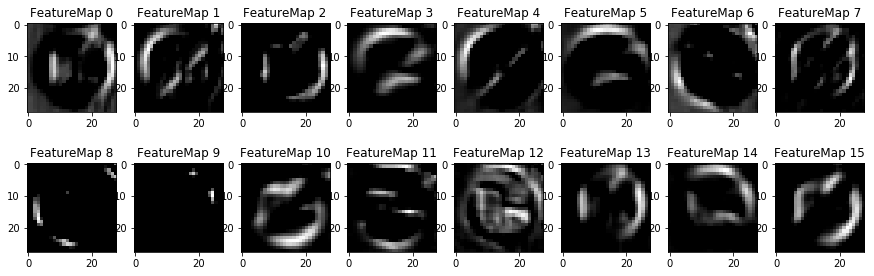

In [38]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
with tf.Session() as sess:
    saver.restore(sess, model_Save_Path)
    outputFeatureMap([X_train_norm[1]], conv1)